In [1]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

#### Read only __date__ and __close price__ from the downloaded quotes file of Nongshim.
___

In [2]:
quotes = pd.read_csv('../data/nongshim_historical_weekly_quotes.csv')
quotes = quotes.rename(columns={'Date': 'week', 'Close': 'close_price'})
quotes = quotes[['week', 'close_price']]

#### Reading the file downloaded from Google Trends website
___

In [3]:
trends = pd.read_csv('../data/bts_google_trends.csv', skiprows=1, sep=",")
trends = trends.rename(columns={'Week': 'week', 'BTS: (Worldwide)': 'search_interest'})

#### Cleaning and assigning __x__ and __y__
___
- Change datatype of __week__ to datetime.
- __x__(independent variable/predictor) = search interest
- __y__(dependent variable/outcome)     = close price
- Moving the dates in __y__ set one back to match the dates in __x__ set.

In [4]:
quotes['week'] = quotes['week'].astype('datetime64[ns]')
trends['week'] = trends['week'].astype('datetime64[ns]')

x = trends.set_index('week')

y = quotes.set_index('week')
y.index = y.index - datetime.timedelta(days=1)

#### Dividing datasets into train and test
___

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=1)

#### Checking if data is skewed
___

In [6]:
print("TRAINING SET\n")

print("1. MEAN")
print("x (search_interest) :: ", np.mean(x_train)[0])
print("y (close price)     :: ", np.mean(y_train)[0])
print("\n")
print("2. MEDIAN")
print("x (search_interest) :: ", np.median(x_train))
print("y (close price)     :: ", np.median(y_train))

TRAINING SET

1. MEAN
x (search_interest) ::  65.43859649122807
y (close price)     ::  282052.63157894736


2. MEDIAN
x (search_interest) ::  63.0
y (close price)     ::  278500.0


##### Mean and Median are similar so the training set isn't skewed by any outliers

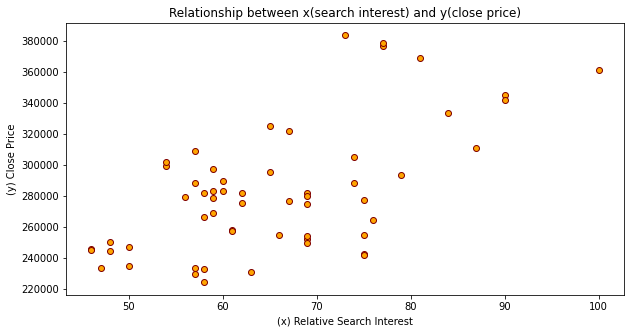

In [7]:
plt.figure(figsize=(10,5))
plt.title('Relationship between x(search interest) and y(close price)')
plt.xlabel("(x) Relative Search Interest") 
plt.ylabel("(y) Close Price") 
plt.scatter(x_train, y_train,  color='orange', edgecolor="maroon")

#### Set up the linear regression model using the training dataset
___

In [8]:
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

print("Correlation      ::", np.sqrt(lm.score(x_train, y_train)), "\n")
print("Coefficient of x ::", lm.coef_[0][0], "\n")
print("Intercept        ::", lm.intercept_[0])

Correlation      :: 0.6104077410491164 

Coefficient of x :: 2087.160662267925 

Intercept        :: 145471.76718843228


##### From the correlation value we can say that it is moderate correlation and not a strong correlation.

#### Predicting the close prices in test dataset using the model fitted above
___
- Predicting close prices using the linear regression model
- Plotting actual close prices against the ones predicted

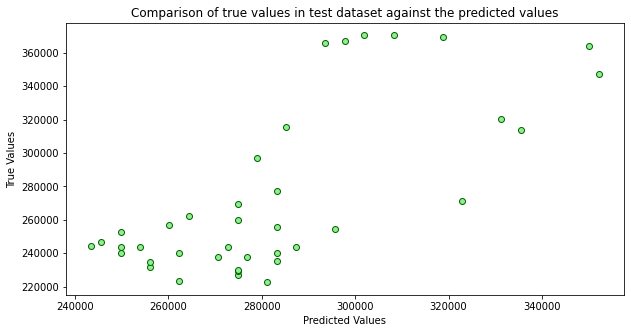

In [9]:
y_predicted = lm.predict(x_test)
plt.figure(figsize=(10,5))
plt.title('Comparison of true values in test dataset against the predicted values')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.scatter(y_predicted, y_test,  color='lightgreen', edgecolor="darkgreen")
plt.show()

#### RMSE (Root-Mean-Square Error)
___

In [10]:
np.sqrt(metrics.mean_squared_error(y_test, y_predicted))

36261.80714945947